# Storms database
Create a database of all North Atlantic hurricanes based on NOAA online archive.

In [1]:
import requests
import re
import pandas as pd
import numpy as np
import epsg
from os.path import exists
from bs4 import BeautifulSoup
from datetime import datetime
from shapely.geometry import Polygon, LineString, Point
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# Set plot size
width = 18
height = 9
plt.rcParams['figure.figsize'] = [width, height]

In [2]:
storms_file = "./storms_database.csv"

In [3]:
# Helper function to set the correct sign for latitudes and longitudes
def convert_latitude_longitude(latitude, longitude):
        lat = 0
        long = 0
        # If latitude contains "N", then remove it and convert it to a +ve float, else remove "S" and convert it to a -ve float.
        if "N" in latitude:
            lat = float(latitude.replace("N", ""))
        else:
            lat = -1 * float(latitude.replace("S", ""))
        # If longitude contains "W", then remove it and convert it to a -ve float, else remove "E" and convert it to a +ve float.
        if "W" in longitude:
            long = -1 * float(longitude.replace("W", ""))
        else:
            long = float(longitude.replace("E", ""))
        return (lat, long)

In [4]:
# Helper function to get the html text from a url.
count_urls_visited = 0
def get_html(url):
    html = None
    while html == None:
        try:
            html = requests.get(url).text
        except Exception as e:
            print("Attempt to access url {} failed with the message {}. Reattempting...".format(url, str(e)))
            continue
    global count_urls_visited
    count_urls_visited += 1
    return html

In [5]:
# Helper function to split a line to list of words.
def line_to_list(line):
    words = [word.strip() for word in line.split()]
    words = list(filter(None, words)) # Remove any empty strings
    return words

In [6]:
# Helper function to read the csv file and convert the strings to numbers and datetime.
def read_csv(file):
    df = pd.read_csv(file)
    time_stamps = []
    path = []
    min_atm_pressures = []
    max_sustained_windspeeds = []
    for i in range(len(df)):
        # Convert the list of strings such as "datetime.datetime(1999, 8, 18, 21, 0)" into datetime object.
        times = df.loc[i, "time_stamps"]
        times = times[1:-1] # Remove "[" and "]"
        times = times.split("datetime.datetime")
        times = list(filter(None, times)) # Remove any empty strings
        times = [item.replace("(", "") for item in times]
        times = [item.replace(")", "") for item in times]
        times = [item.strip() for item in times]
        times = [item[:-1] if item.endswith(",") else item for item in times]
        times = [datetime.strptime(time, '%Y, %m, %d, %H, %M') for time in times]
        time_stamps.append(times)
        # Convert the list of strings such as "(-93.7, 20.1)" into a tuple of numbers.
        points = df.loc[i, "path(longitude, latitude)"]
        points = points[1:-1] # Remove "[" and "]"
        points = points.split(")")
        points = list(filter(None, points)) # Remove any empty strings
        points = [item.replace("(", "") for item in points]
        points = [item[1:].strip() if item.startswith(",") else item for item in points]
        points = [item.split(",") for item in points]
        points = [(float(item[0]), float(item[1])) for item in points]
        path.append(points)
        # Convert the list of strings to numbers
        pressures = df.loc[i, "min_atm_pressure(MB)"]
        pressures = pressures[1:-1] # Remove "[" and "]"
        pressures = pressures.replace("'", "")
        pressures = pressures.split(",")
        pressures = list(filter(None, pressures)) # Remove any empty strings
        pressures = [int(item) for item in pressures]
        min_atm_pressures.append(pressures)
        # Convert the list of strings to numbers
        wind_speeds = df.loc[i, "max_sustained_windspeed(knots)"]
        wind_speeds = wind_speeds[1:-1] # Remove "[" and "]"
        wind_speeds = wind_speeds.replace("'", "")
        wind_speeds = wind_speeds.split(",")
        wind_speeds = list(filter(None, wind_speeds)) # Remove any empty strings
        wind_speeds = [int(item) for item in wind_speeds]
        max_sustained_windspeeds.append(wind_speeds)
    df["time_stamps"] = time_stamps
    df["path(longitude, latitude)"] = path
    df["min_atm_pressure(MB)"] = min_atm_pressures
    df["max_sustained_windspeed(knots)"] = max_sustained_windspeeds
    return df

In [7]:
# Check if the storms file exist
file_exists = exists(storms_file)

df = None
if file_exists:
    df = read_csv(storms_file)
else:
    df = pd.DataFrame(columns=["year", "storm", "time_stamps", "path(longitude, latitude)", "min_atm_pressure(MB)", "max_sustained_windspeed(knots)"])
    # Access the web archive and create a database of storms
    for year in range(1999, 2023, 1):
        url_for_each_year = "https://www.nhc.noaa.gov/archive/{}/".format(year)
        archive_html = get_html(url_for_each_year.format(year)) if year != 2002 else get_html("https://www.nhc.noaa.gov/archive/2002/index.shtml")
        archive_soup = BeautifulSoup(archive_html, "html.parser")
        # Html page contains a table with a list of tropical storms. 
        # In general this will be the only table in the page, but for the years 1999, 2000, 2001 
        # it is the 3rd table.
        tables = archive_soup.find_all("table")
        table = tables[-1]

        # The tables generally have 3 columns for - Atlantic, E. Pacific, and C. Pacific.
        # We ony require Atlantic. Find the column for Atlantic.
        i_atlantic = 0
        for col_header in table.find_all("th"):
            if col_header.get_text() == "Atlantic":
                break
            else:
                i_atlantic += 1
        # Get the list of Atlantic storms for each year.
        storm_list = table.find_all("td")[i_atlantic]
        # From the list, access the web page for each storm using the url for each storm.
        for storm_url in storm_list.find_all("a"):
            # From the list of storms filter our hurricanes.
            if "HURRICANE" in storm_url.get_text() or "Hurricane" in storm_url.get_text():
                storm_name = storm_url.get_text()
                print(year, storm_name)
                storm_url = url_for_each_year+storm_url.get("href")
                storm_html = get_html(storm_url)
                storm_soup = BeautifulSoup(storm_html, "html.parser")
                # Find all forecast advisories. Links to forcast advisories contains the expression "MAL" or ".fstadv.".
                forcast_links = storm_soup.find_all("a", href=[re.compile("MAL"), re.compile(".fstadv.")])
                time_stamps = []
                storm_path = []
                pressures = []
                wind_speeds = []
                for link in forcast_links:
                    link_text = link.get_text()
                    index_and_time_on_link = line_to_list(link_text)
                    time_on_link = index_and_time_on_link[1][:4]
                    forecast_url = "https://www.nhc.noaa.gov{}".format(link.get("href"))
                    forecast_html = get_html(forecast_url)
                    forecast_soup = BeautifulSoup(forecast_html, "html.parser")
                    message = forecast_soup.find("pre").text.splitlines()
                    line_index = 0
                    for line in message:
                        try:
                            line = line.strip()
                            if line.startswith(time_on_link) and line.endswith(str(year)):
                                words = line_to_list(line)
                                # Get timestamp
                                if len(words) >= 5:
                                    year = int(words[-1])
                                    day = int(words[-2])
                                    month_name = words[-3]
                                    time = words[0]
                                    hour = int(time[:2])
                                    mins = int(time[2:4])
                                    # Convert month name to number
                                    month_number = int(datetime.strptime(month_name, "%b").month)
                                    time = datetime(year, month_number, day, hour, mins)
                                    time_stamps.append(time)
                            if "REPEAT...CENTER LOCATED NEAR" in line:
                                words = line_to_list(line)
                                # Get latitude and longitude
                                if len(words) >= 5:
                                    latitude, longitude = convert_latitude_longitude(words[3], words[4])
                                    storm_path.append((longitude, latitude))
                            if "ESTIMATED MINIMUM CENTRAL PRESSURE" in line:
                                words = line_to_list(line)
                                # Get pressure
                                if len(words) >= 5:
                                    pressure = words[4]
                                    pressures.append(pressure)
                            if "MAX SUSTAINED WINDS" in line:
                                words = line_to_list(line)
                                # Get wind speed.
                                if len(words) >= 4:
                                    wind_speed = words[3]
                                    wind_speeds.append(wind_speed)    
                            # Increment line index
                            line_index += 1
                        except Exception as e:
                            print("Error {} while parsing \"{}\". Link for {} {}".format(str(e), line, link_text, link))
                # Append to dataframe
                df.loc[len(df.index)] = [year, storm_name, time_stamps, storm_path, pressures, wind_speeds]             
    df.to_csv("./storms_database.csv")

1999 HURRICANE BRET
1999 HURRICANE CINDY
1999 HURRICANE DENNIS
1999 HURRICANE FLOYD
1999 HURRICANE GERT
1999 HURRICANE IRENE
1999 HURRICANE JOSE
1999 HURRICANE LENNY
2000 HURRICANE ALBERTO
2000 HURRICANE DEBBY
2000 HURRICANE FLORENCE
2000 HURRICANE GORDON
2000 HURRICANE ISAAC
2000 HURRICANE JOYCE
2000 HURRICANE KEITH
2000 HURRICANE MICHAEL
2001 HURRICANE ERIN
2001 HURRICANE FELIX
2001 HURRICANE GABRIELLE
2001 HURRICANE HUMBERTO
2001 HURRICANE IRIS
2001 HURRICANE KAREN
2001 HURRICANE MICHELLE
2001 HURRICANE NOEL
2001 HURRICANE OLGA
2002 HURRICANE GUSTAV
2002 HURRICANE ISIDORE
2002 HURRICANE KYLE
2002 HURRICANE LILI
2003 Hurricane CLAUDETTE
2003 Hurricane DANNY
2003 Hurricane ERIKA*
2003 Hurricane FABIAN
2003 Hurricane ISABEL
2003 Hurricane JUAN
2003 Hurricane KATE
2004 Hurricane ALEX
2004 Hurricane CHARLEY
2004 Hurricane DANIELLE
2004 Hurricane FRANCES
2004 Hurricane GASTON*
2004 Hurricane IVAN
2004 Hurricane JEANNE
2004 Hurricane KARL
2004 Hurricane LISA
2005 Hurricane CINDY*
2005 Hurr

In [8]:
print("Total number of web pages visited = {}".format(count_urls_visited))

Total number of web pages visited = 6095


In [9]:
df

,year,storm,time_stamps,"path(longitude, latitude)",min_atm_pressure(MB),max_sustained_windspeed(knots)
0,1999,HURRICANE BRET,"[1999-08-18 21:00:00, 1999-08-19 03:00:00, 199...","[(-93.7, 20.1), (-94.3, 19.6), (-93.8, 19.9), ...","[1010, 1007, 1007, 1008, 1006, 1000, 999, 993,...","[30, 30, 30, 30, 35, 40, 45, 55, 55, 65, 80, 8..."
1,1999,HURRICANE CINDY,"[1999-08-19 03:00:00, 1999-08-19 09:00:00, 199...","[(-19.4, 13.6), (-21.3, 14.0), (-22.1, 14.1), ...","[1003, 1003, 1003, 1003, 1002, 1002, 1002, 100...","[30, 30, 30, 30, 30, 30, 30, 35, 40, 50, 55, 6..."
2,1999,HURRICANE DENNIS,"[1999-08-24 03:00:00, 1999-08-24 09:00:00, 199...","[(-68.3, 21.1), (-69.1, 21.5), (-71.0, 22.5), ...","[1008, 1008, 1008, 1008, 1005, 1008, 1004, 100...","[30, 30, 30, 45, 40, 40, 40, 55, 55, 65, 65, 7..."
3,1999,HURRICANE FLOYD,"[1999-09-07 21:00:00, 1999-09-08 03:00:00, 199...","[(-46.2, 14.6), (-47.5, 15.2), (-49.1, 15.6), ...","[1008, 1007, 1005, 1003, 1000, 1000, 1003, 100...","[25, 30, 35, 40, 45, 50, 50, 50, 60, 60, 60, 7..."
4,1999,HURRICANE GERT,"[1999-09-11 15:00:00, 1999-09-11 21:00:00, 199...","[(-24.7, 12.3), (-26.8, 13.1), (-28.5, 13.1), ...","[1004, 1004, 1004, 1004, 1001, 996, 994, 990, ...","[30, 30, 30, 30, 35, 55, 60, 60, 65, 75, 75, 9..."
...,...,...,...,...,...,...
176,2022,Hurricane IAN,"[2022-09-23 09:00:00, 2022-09-23 15:00:00, 202...","[(-68.6, 13.9), (-70.1, 14.2), (-71.3, 14.7), ...","[1006, 1006, 1006, 1005, 1003, 1003, 1003, 100...","[30, 30, 30, 35, 40, 40, 40, 45, 45, 45, 40, 5..."
177,2022,Hurricane JULIA,"[2022-10-06 15:00:00, 2022-10-06 21:00:00, 202...","[(-67.0, 11.4), (-68.7, 11.6), (-69.8, 11.9), ...","[1006, 1003, 1004, 1004, 1002, 1002, 999, 999,...","[30, 30, 30, 30, 35, 35, 40, 50, 55, 60, 65, 7..."
178,2022,Hurricane LISA,"[2022-10-30 21:00:00, 2022-10-31 03:00:00, 202...","[(-73.6, 15.7), (-74.9, 15.8), (-76.1, 15.8), ...","[1005, 1005, 1006, 1003, 1002, 1002, 1004, 100...","[35, 35, 35, 35, 40, 40, 40, 50, 55, 60, 60, 7..."
179,2022,Hurricane MARTIN,"[2022-11-01 15:00:00, 2022-11-01 21:00:00, 202...","[(-55.9, 35.3), (-54.5, 35.4), (-53.4, 35.1), ...","[997, 991, 991, 989, 983, 974, 973, 968, 960, ...","[45, 50, 50, 55, 65, 75, 75, 75, 75, 70]"


## Grid map for Gulf of Mexico

In [24]:
# The region of interest
north = 50
south = 15
east = -45
west = -100

In [25]:
# Cells in the grid
cells = []
for latitude in range(south, north, 1):
    for longitude in range(west, east, 1):
        cell = (latitude+1, longitude+1, latitude, longitude) # north, east, south, west
        cells.append(cell)

In [26]:
# Polygons for cells
polygons = []
for cell in cells:
    lat1, long1, lat0, long0 = cell
    long1, lat1 = epsg.GCS_to_PCS(long1, lat1)
    long0, lat0 = epsg.GCS_to_PCS(long0, lat0)
    polygon = Polygon([(long0, lat0), (long1, lat0), (long1, lat1), (long0, lat1)])
    polygons.append(polygon)

In [27]:
# For each cell, find the storms that passed through it
storms_in_cells = []
for i in range(len(polygons)):
    polygon = polygons[i]
    storms_in_cell = []
    for j in range(len(df)):
        year = df.loc[j, "year"]
        storm = df.loc[j, "storm"]
        path = df.loc[j, "path(longitude, latitude)"]
        path = [epsg.GCS_to_PCS(long, lat) for (long, lat) in path]
        path = LineString(path)
        # Check for intersection of path with cell
        intersection = polygon.intersection(path)
        if not intersection.is_empty:
            storms_in_cell.append("{} {}".format(year, storm))
    storms_in_cells.append(storms_in_cell)    

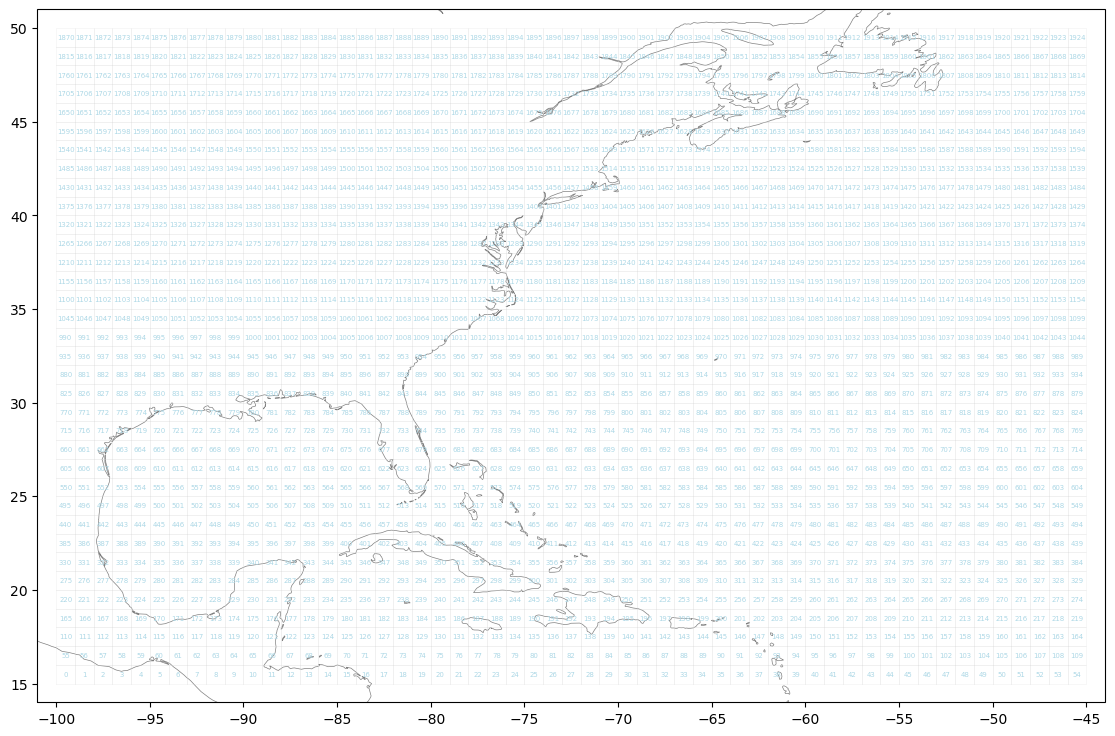

In [29]:
# Plot the grids
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_yticks(range(south, north+1, 5), minor=False)
ax.set_xticks(range(west, east+1, 5), minor=False)
# Set the extent of the plot
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north+1)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot the cells
for i in range(len(polygons)):
    polygon = polygons[i]
    longitudes = []
    latitudes = []
    edges = polygon.boundary
    for point in edges.coords:
        longitude, latitude = epsg.PCS_to_GCS(*point)
        longitudes.append(longitude)
        latitudes.append(latitude)
    plt.plot(longitudes, latitudes, color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.25, transform=ccrs.Geodetic())
    # Also show the cell index at the centre of each cell
    longitude = (max(longitudes) + min(longitudes))/2.0
    latitude = (max(latitudes) + min(latitudes))/2.0
    plt.text(longitude, latitude, str(i), color="lightblue", size=5, ha='center', va='center')
plt.show()

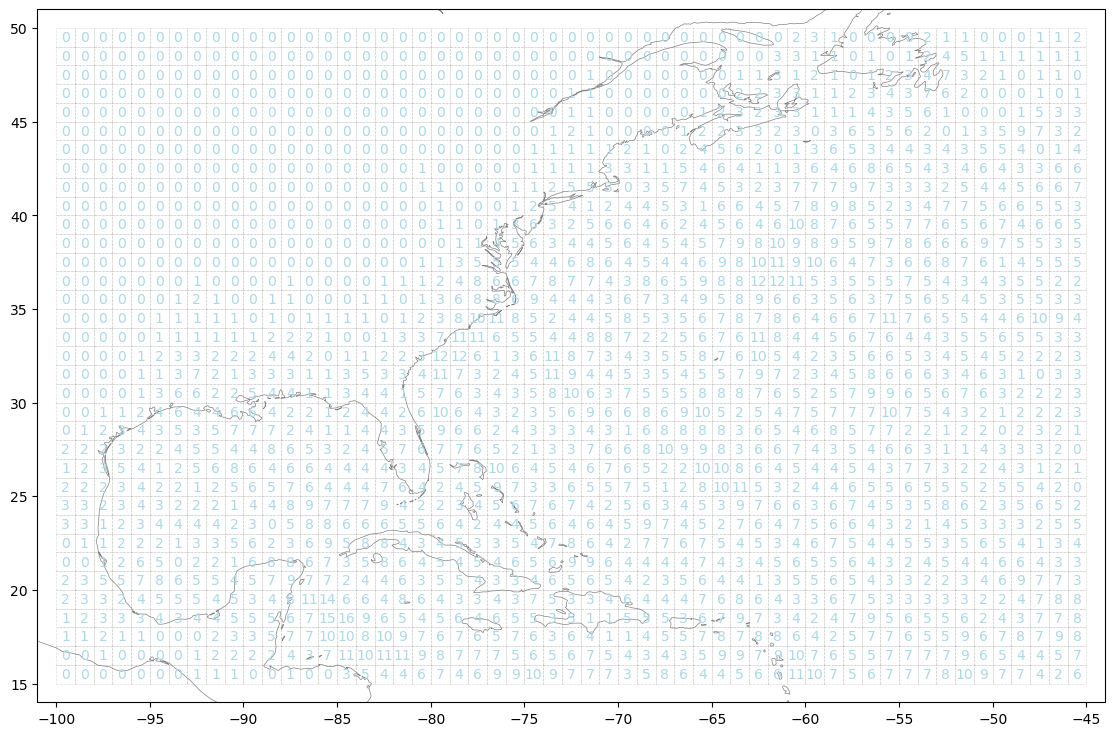

In [15]:
# Plot the storm counts
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_yticks(range(south, north+1, 5), minor=False)
ax.set_xticks(range(west, east+1, 5), minor=False)
# Set the extent of the plot
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north+1)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot the cells
for i in range(len(polygons)):
    polygon = polygons[i]
    longitudes = []
    latitudes = []
    edges = polygon.boundary
    for point in edges.coords:
        longitude, latitude = epsg.PCS_to_GCS(*point)
        longitudes.append(longitude)
        latitudes.append(latitude)
    plt.plot(longitudes, latitudes, color='grey', linestyle='--', linewidth=0.5, alpha=0.25, transform=ccrs.Geodetic())
    # Also show the cell index at the centre of each cell
    longitude = (max(longitudes) + min(longitudes))/2.0
    latitude = (max(latitudes) + min(latitudes))/2.0
    plt.text(longitude, latitude, len(storms_in_cells[i]), color="lightblue", ha='center', va='center')
plt.show()

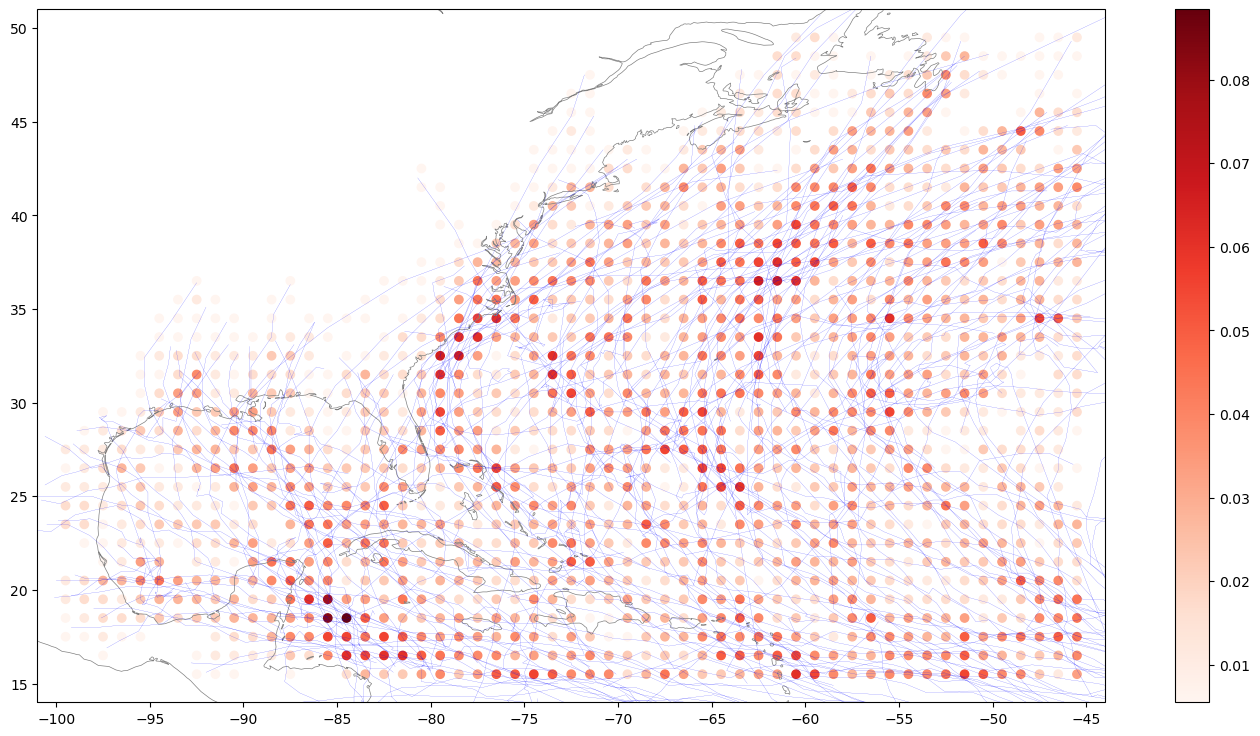

In [16]:
# Plot the storm counts
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_yticks(range(south, north+1, 5), minor=False)
ax.set_xticks(range(west, east+1, 5), minor=False)
# Set the extent of the plot
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north+1)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot storm paths
for i in range(len(df)):
    path = df.loc[i, "path(longitude, latitude)"]
    longitudes = []
    latitudes = []
    for point in path:
        longitude, latitude = point
        longitudes.append(longitude)
        latitudes.append(latitude)
    plt.plot(longitudes, latitudes, color='blue', linewidth=0.1, transform=ccrs.Geodetic())
# Heat map of counts
longitudes = []
latitudes = []
probabilities = []
for i in range(len(polygons)):
    N, E, S, W = cells[i]
    longitude = (E + W)/2.0
    latitude = (N + S)/2.0
    probability = len(storms_in_cells[i])/len(df)
    if probability > 0:
        longitudes.append(longitude)
        latitudes.append(latitude)
        probabilities.append(probability)
sc = plt.scatter(x=longitudes, y=latitudes, c=probabilities, cmap=plt.get_cmap("Reds"))
plt.colorbar(sc)
plt.show()

## Sliding window to identify region of max activity

In [17]:
# Cells in the grid
cells = []
slider_delta = 0.5
cell_size = 5 # 5 lat x 5 long
for latitude in np.arange(south, north-cell_size+1, slider_delta):
    for longitude in np.arange(west, east-cell_size+1, slider_delta):
        cell = (latitude+cell_size, longitude+cell_size, latitude, longitude) # north, east, south, west
        cells.append(cell)

In [18]:
# Polygons for cells
polygons = []
for cell in cells:
    lat1, long1, lat0, long0 = cell
    long1, lat1 = epsg.GCS_to_PCS(long1, lat1)
    long0, lat0 = epsg.GCS_to_PCS(long0, lat0)
    polygon = Polygon([(long0, lat0), (long1, lat0), (long1, lat1), (long0, lat1)])
    polygons.append(polygon)

In [19]:
# For each cell, find the storms that passed through it
storms_in_cells = []
for i in range(len(polygons)):
    polygon = polygons[i]
    storms_in_cell = []
    for j in range(len(df)):
        year = df.loc[j, "year"]
        storm = df.loc[j, "storm"]
        path = df.loc[j, "path(longitude, latitude)"]
        path = [epsg.GCS_to_PCS(long, lat) for (long, lat) in path]
        path = LineString(path)
        # Check for intersection of path with cell
        intersection = polygon.intersection(path)
        if not intersection.is_empty:
            storms_in_cell.append("{} {}".format(year, storm))
    storms_in_cells.append(storms_in_cell)    

In [20]:
max_count = 0
index_max_cell = None
for i in range(len(storms_in_cells)):
    count = len(storms_in_cells[i])
    if count > max_count:
        max_count = count
        index_max_cell = i

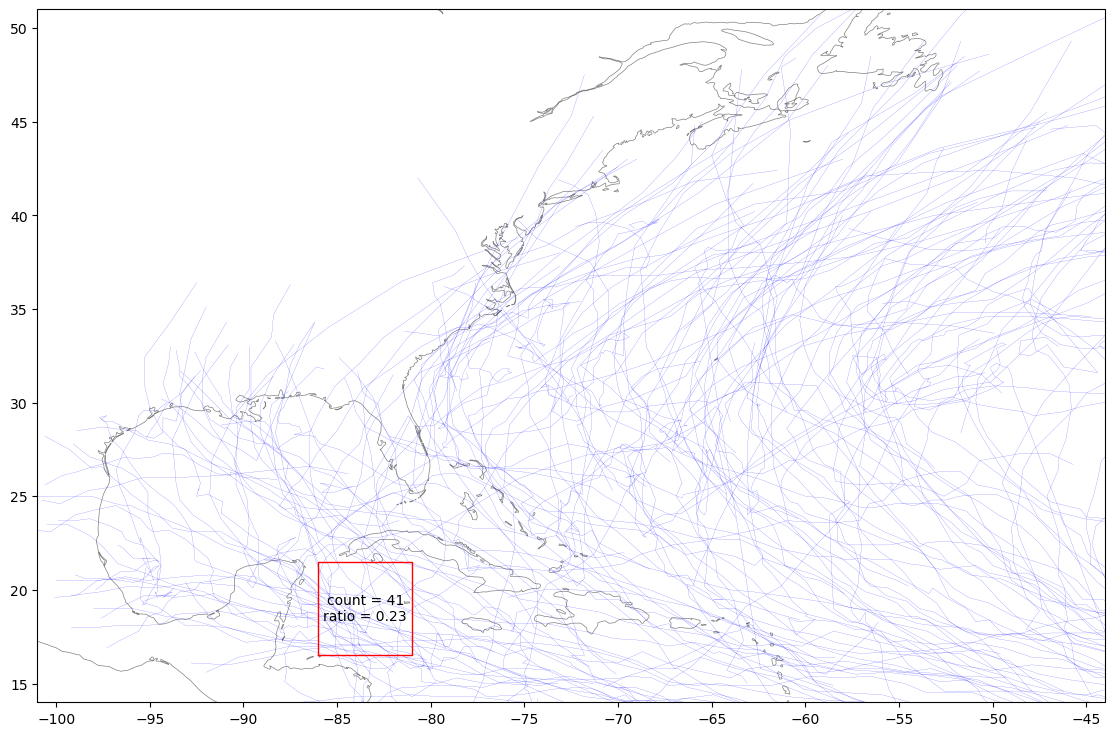

In [21]:
# Plot the grids
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_yticks(range(south, north+1, 5), minor=False)
ax.set_xticks(range(west, east+1, 5), minor=False)
# Set the extent of the plot
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north+1)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot storm paths
for i in range(len(df)):
    path = df.loc[i, "path(longitude, latitude)"]
    longitudes = []
    latitudes = []
    for point in path:
        longitude, latitude = point
        longitudes.append(longitude)
        latitudes.append(latitude)
    plt.plot(longitudes, latitudes, color='blue', linewidth=0.1, transform=ccrs.Geodetic())
# Plot the max cell
polygon = polygons[index_max_cell]
longitudes = []
latitudes = []
edges = polygon.boundary
for point in edges.coords:
    longitude, latitude = epsg.PCS_to_GCS(*point)
    longitudes.append(longitude)
    latitudes.append(latitude)
plt.plot(longitudes, latitudes, color='red', linestyle='-', linewidth=1, transform=ccrs.Geodetic())
# Also show the cell index at the centre of each cell
longitude = (max(longitudes) + min(longitudes))/2.0
latitude = (max(latitudes) + min(latitudes))/2.0
plt.text(longitude, latitude, "count = {}\nratio = {:.2f}".format(max_count, max_count/len(df)), color="black", ha='center', va='center')
plt.show()

In [22]:
print("North {}, East{}, South{}, West{}".format(*cells[index_max_cell]))

North 21.5, East-81.0, South16.5, West-86.0
